# Setup

In [1]:
# check GPU
!nvidia-smi

Sat Jan 14 03:09:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# checkout specific branch if needed
!cd mode_connectivity; git checkout resnet_perm_spec

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 882, done.
remote: Counting objects: 100% (497/497), done.
remote: Compressing objects: 100% (286/286), done.
remote: Total 882 (delta 275), reused 382 (delta 210), pack-reused 385
Receiving objects: 100% (882/882), 37.72 MiB | 25.91 MiB/s, done.
Resolving deltas: 100% (519/519), done.
Branch 'resnet_perm_spec' set up to track remote branch 'resnet_perm_spec' from 'origin'.
Switched to a new branch 'resnet_perm_spec'


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from mode_connectivity.training import *
from mode_connectivity.lmc import *
from mode_connectivity.training_config import *

from mode_connectivity.models.mlp import MLP
from mode_connectivity.models.vgg import VGG
from mode_connectivity.models.resnet import ResNet

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils

import torch
from torchvision import transforms
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# VGG LMC

In [5]:
# pull the required model files
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm1_a.pt 
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm1_b.pt
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm4_a.pt 
!cd mode_connectivity && git lfs pull -I model_files/resnet_wm4_b.pt

Git LFS: (1 of 1 files) 1.06 MB / 1.06 MB
Git LFS: (1 of 1 files) 1.06 MB / 1.06 MB
Git LFS: (1 of 1 files) 16.53 MB / 16.53 MB
Git LFS: (1 of 1 files) 1.06 MB / 1.06 MB


In [15]:
model = ResNet()

ax = model.permutation_spec.axes_to_perm

ps = model.permutation_spec.perm_to_axes

for i, j in ax.items():
    print(i, j)

print()

for i, j in ps.items():
    print(i, j)

conv1.weight ('P_BG_0', None, None, None)
norm1.weight ('P_BG_0',)
norm1.bias ('P_BG_0',)
block_groups.0.blocks.0.conv1.weight ('P_BG_0_IN_0', 'P_BG_0', None, None)
block_groups.0.blocks.0.norm1.weight ('P_BG_0_IN_0',)
block_groups.0.blocks.0.norm1.bias ('P_BG_0_IN_0',)
block_groups.0.blocks.0.conv2.weight ('P_BG_0', 'P_BG_0_IN_0', None, None)
block_groups.0.blocks.0.norm2.weight ('P_BG_0',)
block_groups.0.blocks.0.norm2.bias ('P_BG_0',)
block_groups.0.blocks.1.conv1.weight ('P_BG_0_IN_1', 'P_BG_0', None, None)
block_groups.0.blocks.1.norm1.weight ('P_BG_0_IN_1',)
block_groups.0.blocks.1.norm1.bias ('P_BG_0_IN_1',)
block_groups.0.blocks.1.conv2.weight ('P_BG_0', 'P_BG_0_IN_1', None, None)
block_groups.0.blocks.1.norm2.weight ('P_BG_0',)
block_groups.0.blocks.1.norm2.bias ('P_BG_0',)
block_groups.0.blocks.2.conv1.weight ('P_BG_0_IN_2', 'P_BG_0', None, None)
block_groups.0.blocks.2.norm1.weight ('P_BG_0_IN_2',)
block_groups.0.blocks.2.norm1.bias ('P_BG_0_IN_2',)
block_groups.0.blocks.2.c

In [20]:
n_points = 3
lambdas = torch.linspace(0, 1, steps=n_points)


for wm in [1]:

  (
      permuted_params,
      train_acc_naive,
      test_acc_naive,
      train_acc_perm,
      test_acc_perm,
  ) = linear_mode_connect(
      ResNet, 
      {'width_multiplier': wm},
      f'mode_connectivity/model_files/resnet_wm{wm}_a.pt', 
      f'mode_connectivity/model_files/resnet_wm{wm}_b.pt', 
      'cifar10', 
      n_points=n_points, 
      verbose=2, 
      max_iter=30,
  )

  torch.save(permuted_params, f'mode_connectivity/model_files/resnet_wm{wm}_b_permuted.pt')

  print(train_acc_naive)
  print(test_acc_naive)
  print(train_acc_perm)
  print(test_acc_perm)

Files already downloaded and verified
Files already downloaded and verified

performing naive interpolation
Average loss: 0.0101, Accuracy: (100%)
Average loss: 0.4141, Accuracy: (90%)
point 1/3. lam = 0.0, train loss = 0.01006177074432373, test loss = 0.4141289978027344
Average loss: 6.4063, Accuracy: (11%)
Average loss: 6.4699, Accuracy: (10%)
point 2/3. lam = 0.5, train loss = 6.40631810546875, test loss = 6.4698521484375
Average loss: 0.0088, Accuracy: (100%)
Average loss: 0.4142, Accuracy: (91%)
point 3/3. lam = 1.0, train loss = 0.00883456687927246, test loss = 0.41423408203125

permuting model
iteration 0 P_BG_1: progress 27.031017303466797
tensor(True)
iteration 0 P_BG_1_IN_1: progress 10.236968994140625
tensor(True)
iteration 0 P_BG_2_IN_2: progress 35.703678131103516
tensor(True)
iteration 0 P_BG_0_IN_0: progress 5.9234819412231445
tensor(True)
iteration 0 P_BG_2_IN_1: progress 40.28743362426758
tensor(True)
iteration 0 P_BG_0_IN_2: progress 3.614546775817871
tensor(True)
ite

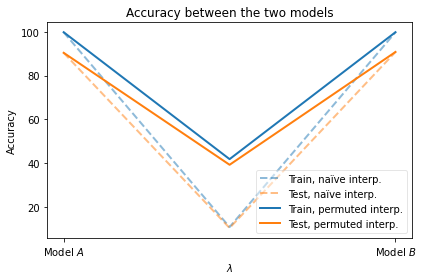

In [21]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

In [31]:
# Now we generate the contour plot
a_params = torch.load("mode_connectivity/model_files/resnet_wm1_a.pt") 
b_params = torch.load("mode_connectivity/model_files/resnet_wm1_b.pt") 
v1, v2, v3 = (
    utils.state_dict_to_numpy_array(p) for p in [a_params, b_params, permuted_params]
)

model_a = ResNet()
model_a.load_state_dict(a_params)

contour_plane = utils.generate_orthogonal_basis(v1, v2, v3)
train_loader, test_loader = data.get_data_loaders(
    dataset="cifar10", train_kwargs={"batch_size":512}, test_kwargs={"batch_size":512}
)
device, _ = get_device()
(
    t1s,
    t2s,
    test_acc_grid,
    test_loss_grid,
    train_acc_grid,
    train_loss_grid,
) = utils.generate_loss_landscape_contour(
    model_a, device, train_loader, test_loader, contour_plane, granularity=5
)

Files already downloaded and verified
Files already downloaded and verified


3it [02:11, 43.81s/it]


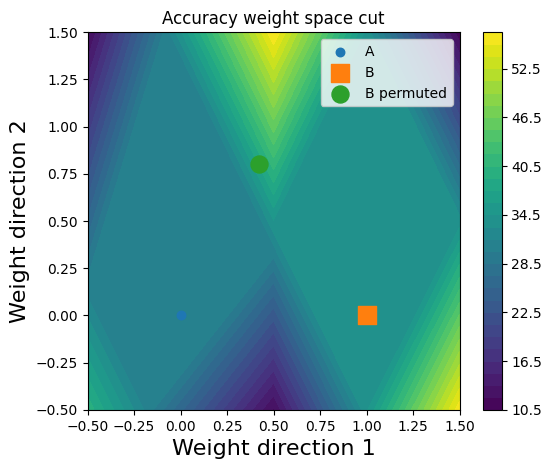

In [32]:
plot.plot_metric_contour(
    "accuracy",
    t1s,
    t2s,
    test_acc_grid,
    model_vectors_dict={
        "A": utils.projection(v1, contour_plane),
        "B": utils.projection(v2, contour_plane),
        "B permuted": utils.projection(v3, contour_plane),
    },
)